In [6]:
import random
import matplotlib.pyplot as plt
import torch
import time
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import cv2
from sklearn.model_selection import train_test_split
from collections import Counter
from PIL import Image
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
import os
import numpy as np
from segmentation_models_pytorch import Unet
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [7]:
id_to_label = {0: 'normal', 1: 'tumor'}
label_to_id = {'normal': 0, 'tumor': 1}

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.targets = []

        for subdir in os.listdir(root_dir):
            if os.path.isdir(os.path.join(root_dir, subdir)):
                for filename in os.listdir(os.path.join(root_dir, subdir)):
                    if filename.endswith(".jpg"):
                        self.images.append(os.path.join(root_dir, subdir, filename))
                        self.targets.append(label_to_id[subdir])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        label = label_to_id[os.path.basename(os.path.dirname(image_path))]
        return image, label

In [8]:
def init(porportion, resize):    
    WBC_1_train_dir = 'WBC_1/train/data'
    WBC_1_train_mask_dir = 'WBC_1/train/mask'
    WBC_1_train_pred_mask_dir = 'WBC_1/train/pred_mask'
    WBC_10_train_dir = 'WBC_10/train/data'
    WBC_10_train_mask_dir = 'WBC_10/train/mask'
    WBC_10_train_pred_mask_dir = 'WBC_10/train/pred_mask'
    WBC_50_train_dir = 'WBC_50/train/data'
    WBC_50_train_mask_dir = 'WBC_50/train/mask'
    WBC_50_train_pred_mask_dir = 'WBC_50/train/pred_mask'
    WBC_100_train_dir = 'WBC_100/train/data'
    WBC_100_train_mask_dir = 'WBC_100/train/mask'
    WBC_100_train_pred_mask_dir = 'WBC_100/train/pred_mask'
    WBC_100_val_dir = 'WBC_100/val/data'
    WBC_100_mask_dir = 'WBC_100/val/mask'
    CAM16_100_train_dir = 'CAM16_100cls_10mask/train/data'
    CAM16_100_train_mask_dir = 'CAM16_100cls_10mask/train/mask'
    CAM16_100_val_dir = 'CAM16_100cls_10mask/val/data'
    CAM16_100_test_dir = 'CAM16_100cls_10mask/test/data'


    WBC_train_dir = 'WBC_' + str(proportion) + '/train/data'
    WBC_mask_dir = 'WBC_' + str(proportion) + '/train/mask'
    WBC_pred_mask_dir ='WBC_' + str(proportion) + '/train/pred_mask'

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(resize),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((resize, resize)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_dataset = CustomDataset(root_dir=CAM16_100_train_dir, transform=train_transform)
    val_dataset = CustomDataset(root_dir=CAM16_100_val_dir, transform=val_transform)


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # if device == torch.device("cuda"):
    #     train_dataset = [(x.to(device), torch.tensor([y]).to(device)) for x, y in train_dataset]
    #     val_dataset = [(x.to(device), torch.tensor([y]).to(device)) for x, y in val_dataset]

    batch_size = 32
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    train_label_counts = Counter(train_dataset.targets)
    val_label_counts = Counter(val_dataset.targets)
    
    return train_dataloader, val_dataloader, train_label_counts, val_label_counts, device

In [9]:
def train(train_dataloader, val_dataloader, train_label_counts, val_label_counts,
          classifier_model_load_path, classifier_model_save_path, 
          mask_model_load_path, device, alpha1, alpha2):
    
    class_counts = []
    
    for label, count in train_label_counts.items():
        class_counts.append(count)
    class_weights = [1.0 / count for count in class_counts]
    
    classifier_model = models.resnet34(pretrained=True)
    mask_model = Unet('resnet34', in_channels=3, classes=1).to(device)
    
    classifier_model.fc = nn.Linear(classifier_model.fc.in_features, 2)
    
    num_layers_to_freeze = 10
    for i, param in enumerate(classifier_model.parameters()):
        if i < num_layers_to_freeze:
            param.requires_grad = False

    criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights)).to(device)

#     criterion = nn.CrossEntropyLoss().to(device)

    lr = 0.001
    epochs = int(10000 / proportion)
    opt = optim.SGD(classifier_model.parameters(), lr=lr, weight_decay=1e-4)
    sch = optim.lr_scheduler.StepLR(opt, int(epochs / 40), 0.8)

    if mask_model_load_path != "":
        mask_model.load_state_dict(torch.load(mask_model_load_path))
        
    if classifier_model_load_path != "":
        classifier_model.load_state_dict(torch.load(classifier_model_load_path))

    if device == torch.device("cuda"):
        classifier_model = classifier_model.to(device)
        mask_model = mask_model.to(device)

    losses = []
    val_accuracies = []
    train_accuracies = []

    mask_model.eval()
    for epoch in range(epochs):
        classifier_model.train()
        correct = 0
        total = 0
        start_time = time.time()
        io_time = 0
        train_time = 0
        eval_time = 0
        running_loss = 0.0
        for inputs, labels in train_dataloader:
            io_start_time = time.time()
            inputs, labels = inputs.to(device), labels.to(device)
            io_time += time.time() - io_start_time
            pred = classifier_model(inputs)
            
            with torch.no_grad():
                pred_mask = mask_model(inputs)
                pred_probability = torch.sigmoid(pred_mask)
                mask = (pred_probability > 0.5)
            masked_loss = criterion(pred, labels) * (mask.float() * alpha1 + alpha2)
            loss = torch.sum(masked_loss) / torch.sum(mask.float())
            
#             loss = criterion(pred, labels)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            running_loss += loss.item()
            _, predicted = torch.max(pred, 1)
            total += len(labels)
            correct += (predicted == labels).sum().item()
        sch.step()
        train_time = time.time() - start_time
        start_time = time.time()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_dataloader)}')
        accuracy = 100 * correct / total
        train_accuracies.append(accuracy)
        print(f'Train Accuracy: {accuracy:.2f}%')
        losses.append(running_loss / len(train_dataloader))

        failed_images = []
        failed_masks = []
        predicted_labels = []
        true_labels = []
        
        error_label_counts = [0 for _ in range(len(val_label_counts))]
        
        if epoch % max(int(epochs/10), 1) == 0:
            classifier_model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in val_dataloader:
                    io_start_time = time.time()
                    inputs, labels = inputs.to(device), labels.to(device)
                    io_time += time.time() - io_start_time
                    pred = classifier_model(inputs)
                    _, predicted = torch.max(pred, 1)
                    total += len(labels)
                    correct += (predicted == labels).sum().item()
                    for i in range(len(labels)):
                        if predicted[i] != labels[i]:
                            predicted_labels.append(predicted[i].item())
                            true_labels.append(labels[i].item())
                            error_label_counts[labels[i]] += 1
                            
#                             if epoch == epochs - 1:
#                                 pred_mask = mask_model(inputs[i].unsqueeze(0))
#                                 pred_probability = torch.sigmoid(pred_mask.squeeze(0).squeeze(0))
#                                 mask = (pred_probability > 0.5)
#                                 failed_masks.append(mask.cpu().numpy())
#                                 failed_images.append(inputs[i].cpu().numpy())
                
                for i in range(len(error_label_counts)):
                    print(id_to_label[i], 'Error Rate: {:.2%}'.format(error_label_counts[i] / val_label_counts[i]))
                
#                 if epoch == epochs - 1:
#                     for i in range(len(failed_images)):
#                         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 16))
#                         ax1.figure.set_size_inches(6, 6)
#                         ax1.imshow(np.transpose(failed_images[i], (1, 2, 0)))
#                         ax1.set_title(f"Pred: {id_to_label[predicted_labels[i]]}, True: {id_to_label[true_labels[i]]}")
#                         ax1.axis('off')

#                         ax2.figure.set_size_inches(6, 6)
#                         ax2.imshow(failed_masks[i], cmap='gray')
#                         ax2.set_title("Predicted Mask")
#                         ax2.axis('off')

#                         plt.show()

            eval_time = time.time() - start_time
            accuracy = 100 * correct / total
            print(f'Validation Accuracy: {accuracy:.2f}%')
            val_accuracies.append(accuracy)
        else:
            val_accuracies.append(val_accuracies[-1])
            
        print('IO:', io_time, 'Train:', train_time, 'Eval:', eval_time)
        
    torch.save(classifier_model.state_dict(), classifier_model_save_path)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    ax1.plot(range(epochs), losses, label='Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss Over Epochs')

    ax2.plot(range(epochs), val_accuracies, label='Validation Accuracy')
    ax2.plot(range(epochs), train_accuracies, label='Train Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy Over Epochs')
    
    ax1.legend()
    ax2.legend()
    plt.tight_layout()
    plt.show()

Epoch 1/100, Loss: 342.57258049647015
Train Accuracy: 54.56%
normal Error Rate: 61.11%
tumor Error Rate: 75.93%
Validation Accuracy: 31.48%
IO: 0.09358930587768555 Train: 13.739752054214478 Eval: 0.46465563774108887
Epoch 2/100, Loss: 339.2553475697835
Train Accuracy: 57.20%
IO: 0.08346247673034668 Train: 13.523530721664429 Eval: 0
Epoch 3/100, Loss: 152.30657847722372
Train Accuracy: 69.22%
IO: 0.07814884185791016 Train: 13.527549266815186 Eval: 0
Epoch 4/100, Loss: 312.88872305552167
Train Accuracy: 68.82%
IO: 0.1093454360961914 Train: 13.487264394760132 Eval: 0
Epoch 5/100, Loss: 116.36235396067302
Train Accuracy: 70.01%
IO: 0.12463760375976562 Train: 13.51202654838562 Eval: 0
Epoch 6/100, Loss: 146.095499197642
Train Accuracy: 70.15%
IO: 0.15574049949645996 Train: 13.488072633743286 Eval: 0
Epoch 7/100, Loss: 141.35864146550497
Train Accuracy: 69.22%
IO: 0.14023685455322266 Train: 13.461607933044434 Eval: 0
Epoch 8/100, Loss: 236.13154363632202
Train Accuracy: 70.15%
IO: 0.04672169

Epoch 65/100, Loss: 91.82658425966899
Train Accuracy: 75.96%
IO: 0.10936880111694336 Train: 14.599167346954346 Eval: 0
Epoch 66/100, Loss: 78.40306790669759
Train Accuracy: 79.00%
IO: 0.14063620567321777 Train: 14.543382167816162 Eval: 0
Epoch 67/100, Loss: 119.16897535324097
Train Accuracy: 75.17%
IO: 0.04687142372131348 Train: 14.415443658828735 Eval: 0
Epoch 68/100, Loss: 107.6551923751831
Train Accuracy: 76.62%
IO: 0.09375667572021484 Train: 14.273461103439331 Eval: 0
Epoch 69/100, Loss: 94.00902684529622
Train Accuracy: 78.07%
IO: 0.06249642372131348 Train: 14.181498527526855 Eval: 0
Epoch 70/100, Loss: 108.69281276067098
Train Accuracy: 74.11%
IO: 0.12940692901611328 Train: 13.513313055038452 Eval: 0
Epoch 71/100, Loss: 77.92982347806294
Train Accuracy: 76.22%
normal Error Rate: 24.07%
tumor Error Rate: 16.67%
Validation Accuracy: 79.63%
IO: 0.08015155792236328 Train: 13.53360366821289 Eval: 0.43150806427001953
Epoch 72/100, Loss: 110.82514142990112
Train Accuracy: 73.32%
IO: 0.0

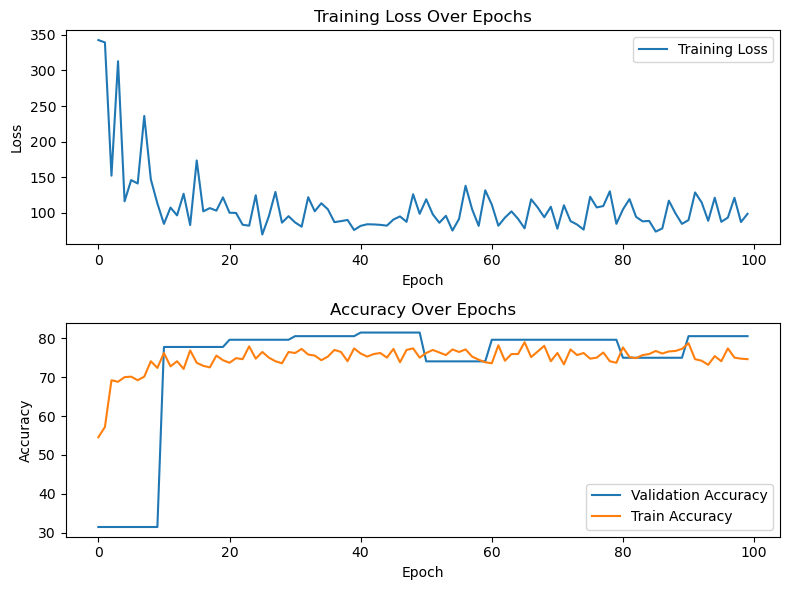

In [10]:
proportion = 100
resize = 224
alpha1 = 0
alpha2 = 1
mask_model_load_path = "UNet_CAM16_model.pth"
classifier_model_load_path = ""
classifier_model_save_path = "Pretrained_ResNet34_CAM16_model.pth"
train_dataloader, val_dataloader, train_label_counts, val_label_counts, device = init(proportion, resize)
train(train_dataloader, val_dataloader, train_label_counts, val_label_counts, classifier_model_load_path, 
      classifier_model_save_path, mask_model_load_path, device, alpha1, alpha2)